In [1]:
import pandas as pd
import numpy as np

/tmp/ipykernel_22290/2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_json('RU_dataset.json')

In [3]:
df = df.rename(columns={0:'Texts', 1:'Annotation'})

In [4]:
with pd.option_context('display.max_colwidth', None):
    display(df.sample(5))

,Texts,Annotation
12885,"У меня ничего не осталось. Моя девушка, с которой мы встречались почти три года, только что разорвала наши отношения, потому что ей кажется, что она не способна любить меня так же, как я люблю ее. Я потерял маму в сентябре 2017 года, когда моя девушка держала меня за руку. Мне не ради чего жить, я планировал свою жизнь после окончания школы вокруг нее, а теперь остался в руинах и одинок. У меня ничего не осталось, нет человека, который мог бы меня понять и полюбить, и не для кого работать. Я просто хочу через какое-то время проползти и умереть.",suicide
30522,"До сих пор я не осознавал, что у меня такая серьезная проблема. Я просто смотрел на кучу таблеток минут пятнадцать. Я в порядке? Я вполне обоснованно думаю, что скоро сделаю это, и мне, вероятно, не помешал бы какой-нибудь совет.",suicide
25852,"Мне больше не нравится ПРЛ, мой разум — это все, чем я являюсь, если у меня его нет, то у меня нет ничего. я только что причинил боль кому-то другому, кто только и делал, что заботился обо мне, потому что я, черт возьми, не могу контролировать свои чувства, клянусь, мне больше нельзя позволять существовать. я отпускаю",suicide
10489,"Раскрой икры, если кто-то напомнит мне, что я знаю, что вы, милашки, хотите увидеть аккуратные икры",non-suicide
39444,"пригласите меня на свои серверы Discord, спасибо",non-suicide


In [5]:
df['Annotation'].unique()

array(['suicide', 'non-suicide'], dtype=object)

In [6]:
df['Target'] = df['Annotation'].apply(lambda x: 1 if x=='suicide' else 0)
df

,Texts,Annotation,Target
0,Бывшая жена угрожает самоубийством Недавно я н...,suicide,1
1,"Я странный? На меня не влияют комплименты, есл...",non-suicide,0
2,Наконец-то 2020 год почти закончился... Так чт...,non-suicide,0
3,"мне нужна помощь, просто помоги мне, я так плачу",suicide,1
4,"Я так растеряна. Здравствуйте, меня зовут Адам...",suicide,1
...,...,...,...
47992,"Я только что увидел забавный мем, прежде чем п...",suicide,1
47993,"Я боюсь, мне некому рассказать. У меня инфекци...",non-suicide,0
47994,"Педофилия, членовредительство и мысли о самоуб...",suicide,1
47995,Я больше не могу справляться. Почти 2 месяца н...,suicide,1


## Data analysis and preprocessing

In [7]:
df['Annotation'].value_counts()

Annotation
non-suicide    24081
suicide        23916
Name: count, dtype: int64

In [8]:
df['Texts'].isna().any()

False

In [9]:
df[df['Texts'] == '']

,Texts,Annotation,Target


In [10]:
df = df.drop_duplicates(subset=['Texts'])

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: ylabel='count'>

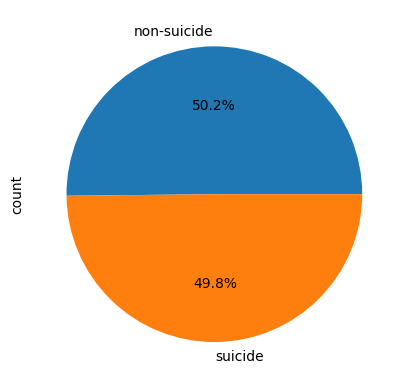

In [12]:
df['Annotation'].value_counts().plot(kind='pie', autopct='%1.1f%%')

*vectorizers*: tf-idf, word2vec
*classifiers*: kNN, LogisticRegressionClassifier, Naive Bayes, SVM

In [13]:
# let's implement preprocess: tokenization, filter by stopwords, normal form
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()
nltk.download('punkt')
sw = stopwords.words('russian')

[nltk_data] Downloading package punkt to /home/byakubson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
def preprocess_normal(doc):
    words = [morph.parse(word.lower())[0].normal_form for word in word_tokenize(doc) if word.isalpha()]
    filtered = [word for word in words if word not in sw]
    return ' '.join(filtered)

In [15]:
def preprocess_tokenize(doc):
    words = [word.lower() for word in word_tokenize(doc) if word.isalpha()]
    filtered = [word for word in words if word not in sw]
    return ' '.join(filtered)

In [16]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [17]:
df['Tokenised'] = df['Texts'].parallel_apply(preprocess_tokenize)
df['Normalised'] = df['Texts'].parallel_apply(preprocess_normal)

/tmp/ipykernel_22290/3381015055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokenised'] = df['Texts'].parallel_apply(preprocess_tokenize)


/tmp/ipykernel_22290/3381015055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Normalised'] = df['Texts'].parallel_apply(preprocess_normal)


In [18]:
with pd.option_context('display.max_colwidth', None):
    display(df[['Texts', 'Tokenised', 'Normalised']].sample(5))

,Texts,Tokenised,Normalised
47510,"Мне просто нужна помощь прямо сейчас, я не знаю, что сказать, я просто не могу перестать плакать и боюсь",просто нужна помощь прямо знаю сказать просто могу перестать плакать боюсь,просто нужный помощь прямо знать сказать просто мочь перестать плакать бояться
9847,"Google Meet - это глупо, как будто я захожу на это уже второй час и нажимаю кнопку выключения камеры, прежде чем вы уходите, чтобы присоединиться (как я почти уверен, что 99,9% этого сабвуфера так и делают), и эта кнопка выключила мою камеру в Экран присоединения к собранию, и он НЕ РАБОТАЕТ. Это привело меня на встречу с включенной камерой. Я не могу физически выразить, насколько мне не понравился этот опыт.",google meet это глупо захожу это второй час нажимаю кнопку выключения камеры прежде уходите присоединиться уверен сабвуфера делают эта кнопка выключила мою камеру экран присоединения собранию работает это привело встречу включенной камерой могу физически выразить насколько понравился опыт,google meet это глупо заходить это второй час нажимать кнопка выключение камера прежде уходить присоединиться уверенный это сабвуфер делать кнопка выключить камера экран присоединение собрание работать это привести встреча включить камера мочь физически выразить насколько понравиться опыт
16859,"леденец – забавное название. я даже не знаю, как они называются\n\nя ем один прямо сейчас, спустя примерно 3 года. У меня были действительно странные правила питания, которые включали только питьевую воду и энергетические напитки. я видел в этом фруктовом мороженое замороженный сок, поэтому просто не стал его есть\n\nочевидно, я не следовал своим «правилам» на 100%, но по какой-то причине это действительно прижилось, но посмотрите на меня сейчас\n\nна самом деле это действительно смешно. я бы отказался от мороженого в жаркий летний день, а затем в ту же ночь выпил бы в четыре раза больше калорий, чем алкоголь\n\nя не знаю, как мой разум так работал, но это так",леденец забавное название знаю называются ем прямо спустя примерно года действительно странные правила питания которые включали питьевую воду энергетические напитки видел фруктовом мороженое замороженный сок поэтому просто стал очевидно следовал своим правилам причине это действительно прижилось посмотрите самом деле это действительно смешно отказался мороженого жаркий летний день затем ту ночь выпил четыре раза калорий алкоголь знаю разум работал это,леденец забавный название знать называться прямо спустя примерно год действительно странный правило питание который включать питьевой вода энергетический напиток видеть это фруктовый мороженое заморозить сок поэтому просто стать очевидный следовать свой правило причина это действительно прижиться посмотреть дело это действительно смешно отказаться мороженое жаркий летний день затем ночь выпить четыре большой калория алкоголь знать разум работать это
31721,"Вы случайно хотели бы, чтобы у вас был близнец? Как будто я просто сижу и случайно думаю: «Было бы круто, если бы у тебя был близнец». Мы оба могли бы носить одинаковую одежду и прически и разыгрывать людей, p.s. Я ЗАВЕВУЮ БЛИЗНЕЦАМ",случайно хотели близнец просто сижу случайно думаю круто близнец оба могли носить одинаковую одежду прически разыгрывать людей завевую близнецам,случайно хотеть близнец просто сидеть случайно думать круто близнец оба мочь носить одинаковый одежда причёска разыгрывать человек завевой близнец
13089,Если ты читаешь этот банан,читаешь банан,читать банан


## Vectorization

In [19]:
from sklearn.model_selection import train_test_split

# for just tokenised
X_train, X_test, y_train, y_test = train_test_split(df['Tokenised'], df['Target'], test_size=0.2, stratify=df['Target'], random_state=42)
# for normalised docs
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(df['Normalised'], df['Target'], test_size=0.2, stratify=df['Target'], random_state=42)

### tf-idf

In [20]:
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_train_transformed = tfidf.fit_transform(X_train)
X_test_transformed = tfidf.transform(X_test)

tfidf_norm = TfidfVectorizer()
X_train_norm_transformed = tfidf_norm.fit_transform(X_train_norm)
X_test_norm_transformed = tfidf_norm.transform(X_test_norm)

### word2vec

In [21]:
# word2vec
from gensim.models import Word2Vec

tokens = [doc.split() for doc in X_train]
w2v_model = Word2Vec(tokens, vector_size=100, window=5, min_count=5, workers=-1)

In [22]:
def vectorize(doc):
    tokens = doc.split()
    token_vecs = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    return np.array(token_vecs).mean(axis=0) if len(token_vecs) != 0 else np.zeros(100)

In [23]:
# tokenised
X2v_train = np.array([vectorize(doc) for doc in X_train])
X2v_test = np.array([vectorize(doc) for doc in X_test])

# normalised
X2v_train_norm = np.array([vectorize(doc) for doc in X_train_norm])
X2v_test_norm = np.array([vectorize(doc) for doc in X_test_norm])

## Classification

In [24]:
# def for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval(y_train, X_train, y_test, X_test, model):
    print(f"""
    Train:
    Accuracy: {round(accuracy_score(y_train, model.predict(X_train)), 3)}
    Precision: {round(precision_score(y_train, model.predict(X_train)), 3)}
    Recall: {round(recall_score(y_train, model.predict(X_train)), 3)}
    F1 score: {round(f1_score(y_train, model.predict(X_train)), 3)}
    
    Test:
    Accuracy: {round(accuracy_score(y_test, model.predict(X_test)), 3)}
    Precision: {round(precision_score(y_test, model.predict(X_test)), 3)}
    Recall: {round(recall_score(y_test, model.predict(X_test)), 3)}
    F1 score: {round(f1_score(y_test, model.predict(X_test)), 3)}
    """)

### TF-IDF

In [25]:
from sklearn.linear_model import LogisticRegression

logclf, logclf_norm = LogisticRegression(n_jobs=-1), LogisticRegression(n_jobs=-1) 
logclf.fit(X_train_transformed, y_train)
logclf_norm.fit(X_train_norm_transformed, y_train)

print('LogisticRegression')
print('Tokenised')
eval(y_train, X_train_transformed, y_test, X_test_transformed, logclf)
print('Normalised')
eval(y_train, X_train_norm_transformed, y_test, X_test_norm_transformed, logclf_norm)

LogisticRegression
Tokenised

    Train:
    Accuracy: 0.943
    Precision: 0.957
    Recall: 0.928
    F1 score: 0.942
    
    Test:
    Accuracy: 0.914
    Precision: 0.932
    Recall: 0.893
    F1 score: 0.912
    
Normalised

    Train:
    Accuracy: 0.94
    Precision: 0.951
    Recall: 0.926
    F1 score: 0.939
    
    Test:
    Accuracy: 0.919
    Precision: 0.932
    Recall: 0.903
    F1 score: 0.918
    


In [26]:
from sklearn.naive_bayes import MultinomialNB

mnbclf, mnbclf_norm  = MultinomialNB(), MultinomialNB() 
mnbclf.fit(X_train_transformed, y_train)
mnbclf_norm.fit(X_train_norm_transformed, y_train)

print('MultinomialNB')
print('Tokenised')
eval(y_train, X_train_transformed, y_test, X_test_transformed, mnbclf)
print('Normalised')
eval(y_train, X_train_norm_transformed, y_test, X_test_norm_transformed, mnbclf_norm)

MultinomialNB
Tokenised

    Train:
    Accuracy: 0.878
    Precision: 0.809
    Recall: 0.987
    F1 score: 0.889
    
    Test:
    Accuracy: 0.832
    Precision: 0.755
    Recall: 0.983
    F1 score: 0.854
    
Normalised

    Train:
    Accuracy: 0.879
    Precision: 0.815
    Recall: 0.98
    F1 score: 0.89
    
    Test:
    Accuracy: 0.861
    Precision: 0.793
    Recall: 0.976
    F1 score: 0.875
    


In [27]:
from sklearn.svm import SVC
import joblib

svc, svc_norm = SVC(random_state=42), SVC(random_state=42)
with joblib.parallel_backend(backend='loky', n_jobs=5):
    svc.fit(X_train_transformed, y_train)
    svc_norm.fit(X_train_norm_transformed, y_train)

print('SVC')
print('Tokenised')
eval(y_train, X_train_transformed, y_test, X_test_transformed, svc)
print('Normalised')
eval(y_train, X_train_norm_transformed, y_test, X_test_norm_transformed, svc_norm)

SVC
Tokenised

    Train:
    Accuracy: 0.988
    Precision: 0.987
    Recall: 0.989
    F1 score: 0.988
    
    Test:
    Accuracy: 0.919
    Precision: 0.934
    Recall: 0.902
    F1 score: 0.918
    
Normalised

    Train:
    Accuracy: 0.983
    Precision: 0.983
    Recall: 0.983
    F1 score: 0.983
    
    Test:
    Accuracy: 0.926
    Precision: 0.936
    Recall: 0.914
    F1 score: 0.925
    


In [28]:
from sklearn.linear_model import SGDClassifier

sgd, sgd_norm = SGDClassifier(n_jobs=-1), SGDClassifier(n_jobs=-1)
sgd.fit(X_train_transformed, y_train)
sgd_norm.fit(X_train_norm_transformed, y_train)

print('SGD')
print('Tokenised')
eval(y_train, X_train_transformed, y_test, X_test_transformed, sgd)
print('Normalised')
eval(y_train, X_train_norm_transformed, y_test, X_test_norm_transformed, sgd_norm)

SGD
Tokenised

    Train:
    Accuracy: 0.943
    Precision: 0.957
    Recall: 0.928
    F1 score: 0.942
    
    Test:
    Accuracy: 0.914
    Precision: 0.931
    Recall: 0.895
    F1 score: 0.912
    
Normalised

    Train:
    Accuracy: 0.94
    Precision: 0.95
    Recall: 0.929
    F1 score: 0.94
    
    Test:
    Accuracy: 0.922
    Precision: 0.932
    Recall: 0.909
    F1 score: 0.921
    


### Word2vec

In [30]:
logclf2v, logclf2v_norm = LogisticRegression(n_jobs=-1), LogisticRegression(n_jobs=-1) 
logclf2v.fit(X2v_train, y_train)
logclf2v_norm.fit(X2v_train_norm, y_train)

print('LogisticRegression')
print('Tokenised')
eval(y_train, X2v_train, y_test, X2v_test, logclf2v)
print('Normalised')
eval(y_train, X2v_train_norm, y_test, X2v_test_norm, logclf2v_norm)

LogisticRegression
Tokenised

    Train:
    Accuracy: 0.661
    Precision: 0.687
    Recall: 0.587
    F1 score: 0.633
    
    Test:
    Accuracy: 0.655
    Precision: 0.68
    Recall: 0.582
    F1 score: 0.627
    
Normalised

    Train:
    Accuracy: 0.678
    Precision: 0.688
    Recall: 0.647
    F1 score: 0.667
    
    Test:
    Accuracy: 0.672
    Precision: 0.679
    Recall: 0.65
    F1 score: 0.664
    


In [32]:
from sklearn.preprocessing import MinMaxScaler #fixed import
scaler = MinMaxScaler()

X2v_train_scaled = scaler.fit_transform(X2v_train)
X2v_test_scaled = scaler.transform(X2v_test)

X2v_train_norm_scaled = scaler.fit_transform(X2v_train_norm)
X2v_test_norm_scaled = scaler.transform(X2v_test_norm)

mnbclf2v, mnbclf2v_norm = MultinomialNB(), MultinomialNB() 
mnbclf2v.fit(X2v_train_scaled, y_train)
mnbclf2v_norm.fit(X2v_train_norm_scaled, y_train)

print('MultinomialNB')
print('Tokenised')
eval(y_train, X2v_train_scaled, y_test, X2v_test_scaled, mnbclf2v)
print('Normalised')
eval(y_train, X2v_train_norm_scaled, y_test, X2v_test_norm_scaled, mnbclf2v_norm)

MultinomialNB
Tokenised

    Train:
    Accuracy: 0.632
    Precision: 0.689
    Recall: 0.478
    F1 score: 0.564
    
    Test:
    Accuracy: 0.632
    Precision: 0.684
    Recall: 0.485
    F1 score: 0.567
    
Normalised

    Train:
    Accuracy: 0.653
    Precision: 0.693
    Recall: 0.543
    F1 score: 0.609
    
    Test:
    Accuracy: 0.64
    Precision: 0.674
    Recall: 0.537
    F1 score: 0.598
    


In [33]:
from sklearn.linear_model import SGDClassifier

sgd2v, sgd2v_norm = SGDClassifier(n_jobs=-1), SGDClassifier(n_jobs=-1)
sgd2v.fit(X2v_train, y_train)
sgd2v_norm.fit(X2v_train_norm, y_train)

print('SGD')
print('Tokenised')
eval(y_train, X2v_train, y_test, X2v_test, sgd2v)
print('Normalised')
eval(y_train, X2v_train_norm, y_test, X2v_test_norm, sgd2v_norm)

SGD
Tokenised

    Train:
    Accuracy: 0.5
    Precision: 0.499
    Recall: 1.0
    F1 score: 0.666
    
    Test:
    Accuracy: 0.5
    Precision: 0.499
    Recall: 1.0
    F1 score: 0.666
    
Normalised

    Train:
    Accuracy: 0.498
    Precision: 0.498
    Recall: 1.0
    F1 score: 0.665
    
    Test:
    Accuracy: 0.498
    Precision: 0.498
    Recall: 1.0
    F1 score: 0.665
    


## Solution

Лучший recall при неплохих других метриках показывает Наивный Байесовский классификатор при приведении токенов к нормальной форме. Теперь можно выбрать гиперпараметры для улучшения модели 

In [48]:
from sklearn.model_selection import GridSearchCV

gridclf = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid = {"alpha": [0.00001, 0.0001, 0.001, 0.1, 1.0, 10, 50, 100, 200, 500]},
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    scoring='roc_auc'
)
gridclf.fit(X_train_norm_transformed, y_train)
print(gridclf.best_params_)
print('Normalised')
eval(y_train, X_train_norm_transformed, y_test, X_test_norm_transformed, gridclf)

{'alpha': 1.0}
Normalised

    Train:
    Accuracy: 0.879
    Precision: 0.815
    Recall: 0.98
    F1 score: 0.89
    
    Test:
    Accuracy: 0.861
    Precision: 0.793
    Recall: 0.976
    F1 score: 0.875
    
